# Create NETCDF from PICKLE

This code loads the data used in analysis and creates a reduced netcdf containing only the historical ship data for distribution.

In [35]:
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot
!pip install gsw
!pip install xarray
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install regionmask

In [36]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [37]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pandas as pd
from scipy.optimize import lsq_linear
from typing import Iterable
from scipy import stats
import pyproj as proj
import scipy.interpolate as interpolate
import regionmask
import scipy.integrate as integrate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import matplotlib.font_manager
#font = {'family': 'serif', 'serif': ['Palatino'], 'size': 14}
#plt.rc('font', **font)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=False)
#plt.rc('text', usetex=False)

In [38]:
# LOAD THE DATA
cutlat = -50 # most Southern Latitude to include

import sys
sys.path.insert(0,'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Finalized Version/src')
from importlib import reload
import loadPickle as loadPickle
reload(loadPickle)
temp_dset = loadPickle.loadPickle('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Finalized Version/data/ALL_CRUISES_v0p8.pkl', cutlat)
cruises_dset = temp_dset
temp_dset

<xarray.Dataset>
Dimensions:                    (index: 534)
Coordinates:
  * index                      (index) int64 10 11 12 13 14 ... 615 616 617 618
Data variables: (12/40)
    Station                    (index) object '40' '40' '40' ... '181' '181'
    Date                       (index) datetime64[ns] 1874-10-08 ... 1906-08-14
    Lat degrees                (index) float64 -39.0 -39.0 -39.0 ... -9.0 -9.0
    Lat minutes                (index) float64 -9.5 -9.5 -9.5 ... -18.0 -18.0
    Lon degrees                (index) float64 20.0 20.0 20.0 ... 112.0 112.0
    Lon minutes                (index) float64 56.0 56.0 56.0 ... 9.0 9.0 9.0
    ...                         ...
    delta_T_seasonal_5564      (index) float64 -1.05 -1.454 ... -0.7273 -0.2845
    WOA_temp_seasonal_5564     (index) float64 18.15 16.85 15.55 ... 8.873 1.416
    delta_T_merged             (index) float64 -0.6061 -0.3704 ... -0.3018
    WOA_temp                   (index) float64 18.59 17.93 16.96 ... 8.995 1.398
    delta_T_merged_5564        (index) float64 -1.832 -1.609 ... -0.8942 -0.2845
    WOA_temp_5564              (index) float64 17.37 16.69 15.22 ... 8.706 1.416

## Now select the subset we care about

In [53]:
ds = xr.Dataset()
ds['Station'] = cruises_dset.Station
ds['Date'] = cruises_dset.Date
ds['lat'] = cruises_dset.lat
ds['lon'] = cruises_dset.lon
ds['cruise'] = cruises_dset.cruise
ds['depth'] = cruises_dset.Depth
ds['temp'] = cruises_dset.Temperature



## ADD METADATA
ds['Station'].attrs = {'info':'Station numbers are as reported for each cruise, and hence are possibly non-unique across all cruises. Note these are stored as strings.'}
ds['Date'].attrs    = {'info':'Date of measurement.'}
ds['lat'].attrs     = {'units':'Degrees latitude'}
ds['lon'].attrs     = {'units':'Degrees longitude'}
ds['cruise'].attrs  = {'info':'Name of originating cruise, options are Gazelle, Valdivia, Planet'}
ds['depth'].attrs   = {'units':'m'}
ds['temp'].attrs    = {'units':'degrees Celsius', 'info':'In-situ temperature as digitized from the original cruise reports, no corrections have been applied to this data.'}
ds.attrs            = {'citation':'Please cite this dataset as Wenegrat, J.O, E. Bonanno, U. Rack, and G. Gebbie, 2022: A century of observed temperature change in the Indian Ocean. Geophysical Research Letters, doi:doi:10.1029/2022GL098217',
                      'notes':'This data has been digitized from the original cruise reports, as described in Wenegrat et al. 2022. Gazelle data was digitized from Table III (beginning page 44) of Forschungsreise S.M.S. Gazelle II Theil: Physik und Chemie.'
                      ' Valdivia data was digitized from the temperature tables beginning on page 137 of Deutsche Tiefsee-Expedition 1898-1899 Bd. 1.'
                      ' Planet data was digitized from the data tables beginning on page 56 of Forschungsreise S.M.S. Planet 1906/7 III. Band Ozeanographie.'
                      ' In each case data was digitized using independent double-entry and checked for consistency. A number of stations from the original data are not included in this dataset due to quality control concerns as documented in Wenegrat et al. 2022.',
                      }

ds

<xarray.Dataset>
Dimensions:  (index: 534)
Coordinates:
  * index    (index) int64 10 11 12 13 14 15 16 ... 612 613 614 615 616 617 618
Data variables:
    Station  (index) object '40' '40' '40' '40' '40' ... '181' '181' '181' '181'
    Date     (index) datetime64[ns] 1874-10-08 1874-10-08 ... 1906-08-14
    lat      (index) float64 -39.16 -39.16 -39.16 -39.16 ... -9.3 -9.3 -9.3 -9.3
    lon      (index) float64 20.93 20.93 20.93 20.93 ... 112.2 112.2 112.2 112.2
    cruise   (index) object 'Gazelle' 'Gazelle' 'Gazelle' ... 'Planet' 'Planet'
    depth    (index) float64 0.0 55.0 91.0 183.0 ... 125.0 150.0 400.0 3.32e+03
    temp     (index) float64 19.2 18.3 16.5 13.2 11.0 ... 20.0 16.9 15.7 9.6 1.7
Attributes:
    citation:  Please cite this dataset as Wenegrat, J.O, E. Bonanno, U. Rack...
    notes:     This data has been digitized from the original cruise reports,...

In [54]:
# Make a quick test plot
cruise = 'Gazelle'

station = '92'

temp = ds.where(ds.cruise==cruise, drop=True)#.where(ds.Station==station, drop=True)
temp
#plt.plot(temp.temp, -temp.depth, marker = 'x')

<xarray.Dataset>
Dimensions:  (index: 281)
Coordinates:
  * index    (index) int64 10 11 12 13 14 15 16 ... 307 308 309 310 311 312 313
Data variables:
    Station  (index) object '40' '40' '40' '40' '40' ... '92' '92' '92' '92'
    Date     (index) datetime64[ns] 1874-10-08 1874-10-08 ... 1875-05-05
    lat      (index) float64 -39.16 -39.16 -39.16 ... -16.18 -16.18 -16.18
    lon      (index) float64 20.93 20.93 20.93 20.93 ... 117.5 117.5 117.5 117.5
    cruise   (index) object 'Gazelle' 'Gazelle' ... 'Gazelle' 'Gazelle'
    depth    (index) float64 0.0 55.0 91.0 ... 1.28e+03 1.646e+03 5.523e+03
    temp     (index) float64 19.2 18.3 16.5 13.2 11.0 ... 6.7 4.2 4.2 2.0 0.9
Attributes:
    citation:  Please cite this dataset as Wenegrat, J.O, E. Bonanno, U. Rack...
    notes:     This data has been digitized from the original cruise reports,...

In [58]:
# Documenting changes to datasets:
##################################
#GazelleValdiviaPlanet_v1p0.nc - Version from pickle v0p8, on manuscript acceptance
ds.to_netcdf('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Finalized Version/data/GazelleValdiviaPlanet_v1p0.nc')

In [59]:
dsnew = xr.open_dataset('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Finalized Version/data/GazelleValdiviaPlanet_v1p0.nc')

dsnew

<xarray.Dataset>
Dimensions:  (index: 534)
Coordinates:
  * index    (index) int64 10 11 12 13 14 15 16 ... 612 613 614 615 616 617 618
Data variables:
    Station  (index) object ...
    Date     (index) datetime64[ns] ...
    lat      (index) float64 ...
    lon      (index) float64 ...
    cruise   (index) object ...
    depth    (index) float64 ...
    temp     (index) float64 ...
Attributes:
    citation:  Please cite this dataset as Wenegrat, J.O, E. Bonanno, U. Rack...
    notes:     This data has been digitized from the original cruise reports,...

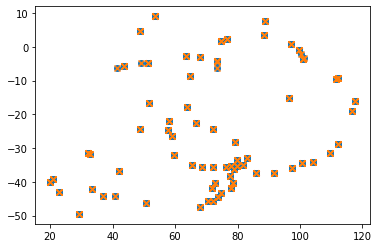

In [61]:
plt.scatter(dsnew.lon, dsnew.lat)
plt.scatter(ds.lon, ds.lat, marker='x')

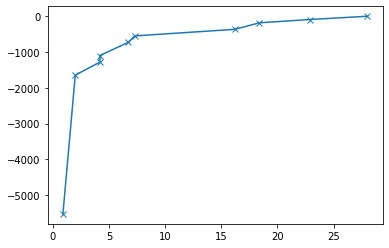

In [62]:
# Make a quick test plot
cruise = 'Gazelle'

station = '92'

temp = dsnew.where(ds.cruise==cruise, drop=True).where(ds.Station==station, drop=True)

plt.plot(temp.temp, -temp.depth, marker = 'x')

In [63]:
dsnew.close()